# 1-qubit contorol simulation

In [12]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jit
from functools import partial
from jax.scipy.linalg import expm
import jax

import sys
sys.path.append("/home/users/u0001529/ondemand/qax")

%load_ext autoreload
%autoreload 2
from qax.dynamics import state as qs
from qax import operators as qo
from qax import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System Hamiltonian

<div style="text-align: center">
<img src="./figures/transmon-resonator.png" width="500" height="400">
</div>

The Hamiltonian for a single transmon and a resonator can be written as follows:
$$
\begin{align}
\hat{H}_{\rm 1q} / \hbar &= \left\{ \omega_{\rm q} - \chi \left( 1 + 2 \hat{a}^\dagger \hat{a} \right) \right\} \frac{\hat{\sigma}_{\rm z}}{2} + \omega_{\rm r} \hat{a}^\dagger \hat{a} \\
\hat{H}_{\rm drive} / \hbar &= \Omega (t) \left( \hat{a}^\dagger e^{-i\omega_{\rm d}t} + \hat{a} e^{i\omega_{\rm d}t} \right) + \frac{\Omega (t)}{\Delta_{\rm qr}} g \left( \hat{\sigma}_+ e^{-i\omega_{\rm d}t} + \hat{\sigma}_-e^{i\omega_{\rm d}t} \right)
\end{align}
$$
full Hamiltonian:

$$
\begin{align}
\hat{H}_{\rm full} / \hbar 
&= \hat{H}_{\rm 1q} + \hat{H}_{\rm drive} \\
&= \left\{ \omega_{\rm q} - \chi \left( 1 + 2 \hat{a}^\dagger \hat{a} \right) \right\} \frac{\hat{\sigma}_{\rm z}}{2} + \omega_{\rm r} \hat{a}^\dagger \hat{a} + \Omega (t) \left( \hat{a}^\dagger e^{-i\omega_{\rm d}t} + \hat{a} e^{i\omega_{\rm d}t} \right) + \frac{\Omega (t)}{\Delta_{\rm qr}} g \left( \hat{\sigma}_+ e^{-i\omega_{\rm d}t} + \hat{\sigma}_-e^{i\omega_{\rm d}t} \right)
\end{align}
$$
We
$$
\begin{align}
\hat{H}_{\rm full}^{\rm rot} / \hbar 
&= \left( \omega_{\rm r}-\omega_{\rm d}  \right) \hat{a}^\dagger \hat{a} + \Omega (t) \left( \hat{a}+\hat{a}^\dagger \right) + \left[ \omega_{\rm q}-\chi \left( 1+2\hat{a}^\dagger \hat{a} \right) -\omega_{\rm d} \right] \frac{\hat{\sigma}_{\rm z}}{2} - \frac{4g \Omega (t)}{\Delta_{\rm qr}} \frac{\hat{\sigma}_{\rm x}}{2}
\end{align}
$$
We consider the case of $\omega_{\rm d} = \omega_{\rm q}-\chi$
$$
\begin{align}
\hat{H}_{\rm full}^{\rm rot} / \hbar 
&= 
\end{align}
$$

Summary of one transmon control Hamiltonian
$$
\begin{align}
{\rm 2-level approximation} : \hat{H}_{\rm full}^{\rm rot}
\end{align}
$$

$$
\begin{align*}
\hat{H}_{\rm 1q} &= \\
\hat{U}_{\rm eval}(\tau) 
&= \exp \left( -i \hat{H}_{\rm 1q} \tau / \hbar \right) \\
&= 
\begin{pmatrix} 
  a_{11} & a_{12} & \dots  & a_{1n} \\
  a_{21} & a_{22} & \dots  & a_{2n} \\
  \vdots & \vdots & \ddots & \vdots \\
  a_{m1} & a_{m2} & \dots  & a_{mn}
\end{pmatrix} 
\end{align*}
$$

In [36]:
# parameter settings
hbar = 1
w_ge = 2*jnp.pi * 5.627*10**9 
w_gf = 2*jnp.pi * 5.480*10**9 
w_r = 2*jnp.pi * 7.433*10**9
delta_qr = w_r - w_ge # difference of freq between transmon & resonator
alpha = 2*(w_gf - w_ge) # anharmonicity
chi = 2*jnp.pi * 2.5*10**6 # dispersice shift

# operator settings
n_photon = 10**3
a = jnp.kron(qo.identity(2), qo.annihilate(n_photon))
a_dag = jnp.kron(qo.identity(2), qo.create(n_photon))
pauli_z = jnp.kron(qo.pauli_z(), qo.identity(n_photon))
pauli_x = jnp.kron(qo.pauli_x(), qo.identity(n_photon))

# initial state
init_state = jnp.kron(qs.n_qubit(1), qs.vaccum(n_photon)) # |qubit, resonator>

# Hamiltonian
H =  
#teval_ops = expm(H)

## Rabi oscillation

### Schrodinger equation solver

In [ ]:
@partial(jit, static_argnums=(0, 1, 2, 3, 4, ))
def Schrodinger(H: jax.Array, init_vec: jax.Array, t_save: jax.Array) -> jax.Array:
    """
    Solve the Schrodinger equation.
    Args:
        H: Hamiltonian
        init_vec: initial state vector
        t_span: tuple, (t_start, t_end), the time range.
        dt: float, time step.
        hbar: float, Planck's constant divided by 2π (default: 1.0).
    
    Returns:
        t_vals: jnp.ndarray, array of time points.
        rho_t: jnp.ndarray, array of density matrices at each time point.
    """
    rhs = -1.0j * H
    equation = lambda t, vec, args: rhs
    ode = ODETerm(equation)
    integrator = Dopri5()
    saveat = SaveAt(ts=jnp.arange(start_time, end_time, time_step))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    solver = diffeqsolve(ode, integrator, t0=start_time, t1=end_time, dt0=step_time, y0=vec_0, saveat=saveat, stepsize_controller=stepsize_controller)
    
    return solver

In [ ]:
@partial(jit, static_argnums=(0, 1, 2, 3, 4, ))
def constant(amp, dt) -> float:
    f = lambda amp, t, freq: jnp.where(jnp.sin(2 * jnp.pi * frequency * t) >= 0, amp, 0.0)
    return 

In [ ]:
class Pulse_Scheduler(self, ):
    def 

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

@partial(jit, static_argnums=(0, 1, 2, 3, ))
@jax.vmap
def gaussian(t: jnp.float64, amp: jnp.complex64, width: jnp.float64, center: jnp.float64) -> jax.Array:
    """
    
    """
    return amp * jnp.exp(-(t-center)**2 / (2*width**2))

amp = 1.0
width = 10.0 * 10**(-9)
center = 5.0 * 10**9
pulse = gauusian(jnpo

In [11]:
jnp.linspace(0, 1.0*10e-6, 10)

Array([0.0000000e+00, 1.1111111e-06, 2.2222223e-06, 3.3333336e-06,
       4.4444446e-06, 5.5555556e-06, 6.6666671e-06, 7.7777777e-06,
       8.8888892e-06, 9.9999997e-06], dtype=float32)

In [ ]:
pulse_info = {"amplitude": ,
              "t_start": ,
              "t_end": ,
              ""}

In [16]:
def square(amp=1.0, time_info: dict):
    r"""
    
    """
    return 0

def gaussian(t, center, sigma, amp=1.0):
    r"""
    
    """
    return amp * jnp.exp(-((t - center) ** 2) / (2 * sigma ** 2))


time_info = {"start": , "end": , ""
# パラメータ設定
center = 50.0      # パルス中心の時間
sigma = 10.0       # パルス幅
amplitude = 1.0    # 振幅

# 時間軸の定義（例として0〜100の範囲を1000点でサンプリング）
t = jnp.linspace(0, 100, 1000)

# パルス生成
pulse = gaussian(t, amplitude)

# パルスをプロットして確認
plt.plot(t, amplitude)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Pulse for Qubit Control")
plt.show()

SyntaxError: non-default argument follows default argument (3879593140.py, line 1)

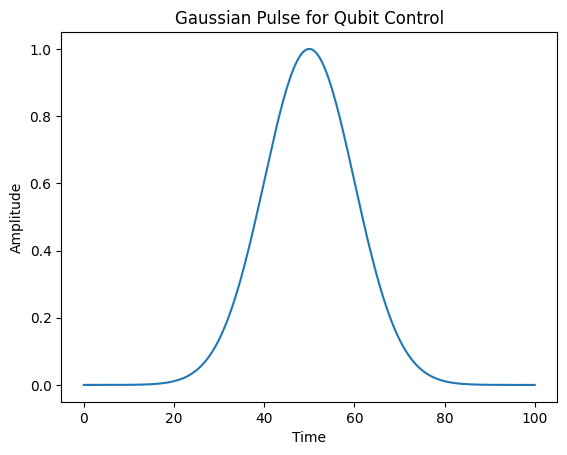

In [17]:
def constant_pulse(t, amplitude=1.0):
    r"""
    
    """
    return amplitude * jnp.exp(-((t - center) ** 2) / (2 * sigma ** 2))

# パラメータ設定
sigma = 10.0       # パルス幅
amplitude = 1.0    # 振幅

# 時間軸の定義（例として0〜100の範囲を1000点でサンプリング）
t = jnp.linspace(0, 100, 1000)

# ガウスパルス生成
pulse = gaussian_pulse(t, center, sigma, amplitude)

# パルスをプロットして確認
plt.plot(t, pulse)
plt.xlabel("Time")
plt.ylabel("Amplitude")
#plt.title("Gaussian Pulse for Qubit Control")
plt.show()

In [ ]:
class PulseScheduler:
    def __init__(self, n_element: int, t_tot: float):
        self.n_element = n_element
        self.t_tot = t_tot

    def add(self, ):
        

    def sequence_plot():

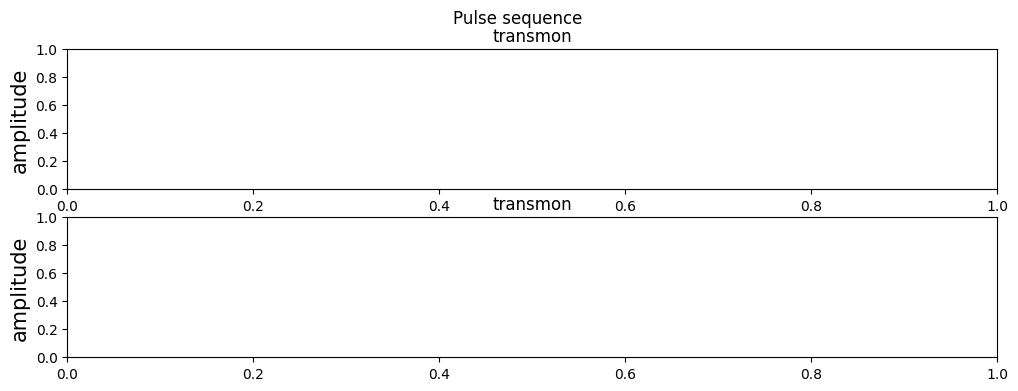

In [8]:
n_element = 2
t_tot = 1.0 * 10e-3

def sequence_plot():
    fig = plt.figure(figsize=(12,4))
    fig.suptitle("Pulse sequence")
    for i in range(n_element):
        ax = fig.add_subplot(n_element, 1, i+1)
        ax.set_title("transmon")
        ax.set_ylabel("amplitude", fontsize=15)

sequence_plot()

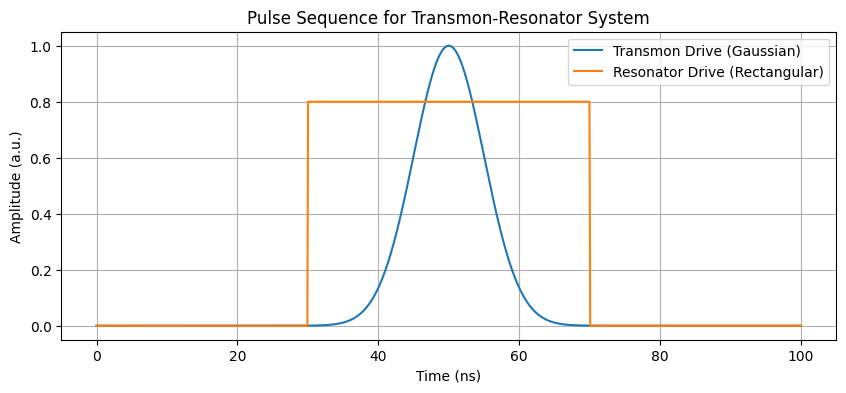

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 時間軸の定義（例: 0〜100 ns, 1000点）
t = np.linspace(0, 100, 1000)

# ガウスパルスの定義（トランスモン駆動用）
def gaussian_pulse(t, t0, sigma, amplitude):
    return amplitude * np.exp(- (t - t0)**2 / (2 * sigma**2))

# 矩形パルスの定義（共振器駆動用）
def rectangular_pulse(t, t_start, t_end, amplitude):
    return amplitude * ((t >= t_start) & (t <= t_end)).astype(float)

# パルスパラメータの設定
transmon_t0 = 50      # ガウスパルスの中心時間
transmon_sigma = 5    # ガウスパルスの幅
transmon_amp = 1.0    # ガウスパルスの振幅

resonator_start = 30  # 矩形パルスの開始時間
resonator_end = 70    # 矩形パルスの終了時間
resonator_amp = 0.8   # 矩形パルスの振幅

# 各パルスの生成
pulse_transmon = gaussian_pulse(t, transmon_t0, transmon_sigma, transmon_amp)
pulse_resonator = rectangular_pulse(t, resonator_start, resonator_end, resonator_amp)

# パルスシーケンスのプロット
plt.figure(figsize=(10, 4))
plt.plot(t, pulse_transmon, label="Transmon Drive (Gaussian)")
plt.plot(t, pulse_resonator, label="Resonator Drive (Rectangular)")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")
plt.title("Pulse Sequence for Transmon-Resonator System")
plt.legend()
plt.grid(True)
plt.show()

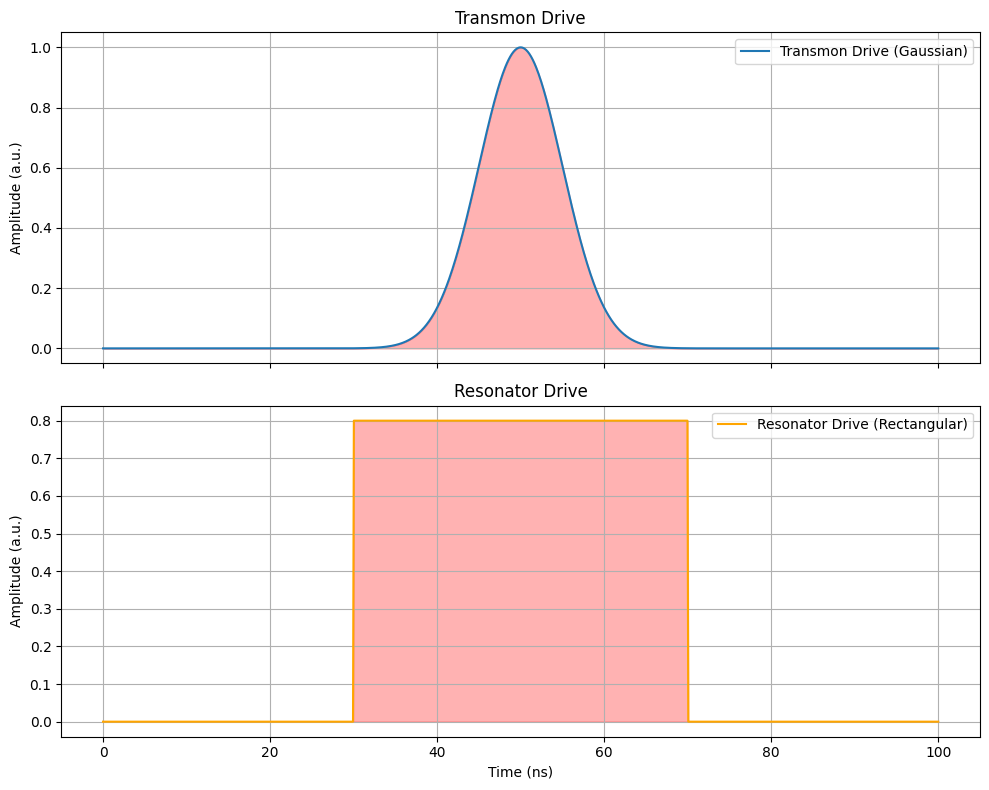

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 時間軸の定義（例: 0〜100 ns, 1000点）
t = np.linspace(0, 100, 1000)

# ガウスパルスの定義（トランスモン駆動用）
def gaussian_pulse(t, t0, sigma, amplitude):
    return amplitude * np.exp(- (t - t0)**2 / (2 * sigma**2))

# 矩形パルスの定義（共振器駆動用)
def rectangular_pulse(t, t_start, t_end, amplitude):
    return amplitude * ((t >= t_start) & (t <= t_end)).astype(float)

#def DRAG(t, t_start, t_end, amplitude):
    

# パルスパラメータの設定
transmon_t0 = 50      # ガウスパルスの中心時間
transmon_sigma = 5    # ガウスパルスの幅
transmon_amp = 1.0    # ガウスパルスの振幅

resonator_start = 30  # 矩形パルスの開始時間
resonator_end = 70    # 矩形パルスの終了時間
resonator_amp = 0.8   # 矩形パルスの振幅

# 各パルスの生成
pulse_transmon = gaussian_pulse(t, transmon_t0, transmon_sigma, transmon_amp)
pulse_resonator = rectangular_pulse(t, resonator_start, resonator_end, resonator_amp)

# サブプロットの作成（2行1列）
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# トランスモン駆動のプロットと塗りつぶし
ax[0].plot(t, pulse_transmon, label="Transmon Drive (Gaussian)")
ax[0].fill_between(t, pulse_transmon, color='red', alpha=0.3)
ax[0].set_ylabel("Amplitude (a.u.)")
ax[0].set_title("Transmon Drive")
ax[0].legend()
ax[0].grid(True)

# 共振器駆動のプロットと塗りつぶし
ax[1].plot(t, pulse_resonator, label="Resonator Drive (Rectangular)", color='orange')
ax[1].fill_between(t, pulse_resonator, color='red', alpha=0.3)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Amplitude (a.u.)")
ax[1].set_title("Resonator Drive")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [22]:
t = jnp.linspace(0, 100, 1000)

pulse1_time_info = {"start": 1.0 * 10e-9, "end": 2.0 * 10e-9}
pulse2_time_info = {"start": 1.0 * 10e-9, "end": 2.0 * 10e-9}

# pulse_shape.py
def square(t, pulse_time_info: dict, amp: float):
    return amp * ((t >= pulse_time_info["start"]) & (t <= pulse_time_info["end"])).astype(float)

def gaussian(t, pulse_time_info: dict, amp: float):
    sd = pulse_time_info["end"] - pulse_time_info["start"]
    center = pulse_time_info["start"] + sd/2
    
    return amp * jax.lax.exp(- (t - center)**2 / (2 * sd**2))

#def drag(t, pulse_time_info: dict, amp: float, center: float):
    

In [ ]:
class PulseScheduler:
    def __init__(self, n_element: int, tot_seq_time: float):
        self.n_element = n_element
        self.tot_seq_time = tot_seq_time

    def pulse_add
        
    def sequence_plot(self, ):
        fig = plt.figure(figsize=(12,4))
        fig.suptitle("Pulse sequence")
        
        for i in range(n_element):
            ax = fig.add_subplot(n_element, 1, i+1)
            ax.set_title("transmon")
            ax.set_ylabel("amplitude", fontsize=15)

In [14]:
jax.lax.exp(1.0)

Array(2.7182817, dtype=float32, weak_type=True)

In [28]:
import jax
import jax.numpy as jnp

# パルスの時間情報（単位は秒）
pulse1_time_info = {"start": 1.0e-9, "end": 2.0e-9}

def gaussian(t, pulse_time_info: dict, amp: float):
    # パルス幅
    sd = pulse_time_info["end"] - pulse_time_info["start"]
    # 中心は開始時刻から sd/2 を足したもの
    center = pulse_time_info["start"] + sd / 2
    return amp * jnp.exp(- (t - center)**2 / (2 * sd**2))

# 例として、特定の時刻 t0 で計算する
t0 = 1.5e-9  # スカラー値

# 例2: 時刻 t に対する微分を計算する場合
gaussian_t = lambda t: gaussian(t, pulse1_time_info, amp=1.0)

grad_time_at_t0 = jax.grad(gaussian_t)(t0)
print("t0 における t に対する勾配:", grad_time_at_t0)

t0 における t に対する勾配: -0.0


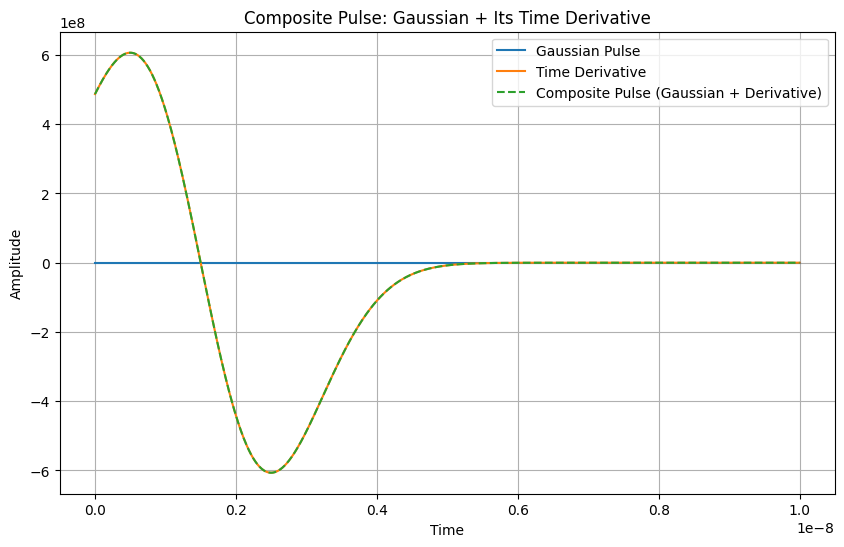

In [32]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# パルスの時間情報（単位：秒）
pulse_time_info = {"start": 1.0e-9, "end": 2.0e-9}

# ガウシアンパルスの定義
def gaussian(t, pulse_time_info: dict, amp: float):
    sd = pulse_time_info["end"] - pulse_time_info["start"]  # パルス幅
    center = pulse_time_info["start"] + sd / 2              # 中心時刻
    return amp * jnp.exp(- (t - center)**2 / (2 * sd**2))

# スカラー入力 t に対するガウシアンパルス（amp=1.0固定）をlambda式で定義
gaussian_t = lambda t: gaussian(t, pulse_time_info, amp=1.0)

# 時刻 t に対する微分を求める（スカラー t 用）
grad_gaussian = jax.grad(gaussian_t)

# 時間軸の定義（例：0〜100、1000点）
t = jnp.linspace(0, 1.0e-8, 1000)

# 配列 t に対して各時刻で計算するために vmap を利用
gaussian_vals = jax.vmap(gaussian_t)(t)
gaussian_deriv = jax.vmap(grad_gaussian)(t)

# 合成パルス：ガウシアンパルスとその時間微分の和
composite_pulse = gaussian_vals - gaussian_deriv

# プロット
plt.figure(figsize=(10, 6))
plt.plot(t, gaussian_vals, label="Gaussian Pulse")
plt.plot(t, gaussian_deriv, label="Time Derivative")
plt.plot(t, composite_pulse, label="Composite Pulse (Gaussian + Derivative)", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Composite Pulse: Gaussian + Its Time Derivative")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def drag(t, pulse_time_info: dict, amp: float, center: float):
    